In this lab we are going to incorporate various classification models to predict whether is at risk of a heart attack.

In [123]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score


In [124]:
#Load and prepare data
heart = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
heart = heart.dropna()
heart.rename(columns={'output': 'risk', 'cp': 'chestpain', 'trtbps': 'rbps', 'thalach': 'maxrate'}, inplace=True)
heart['risk'] = heart['risk'].astype('category')
heart['sex'] = heart['sex'].astype('category')
heart['chestpain'] = heart['chestpain'].astype('category')
heart['restecg'] = heart['restecg'].astype('category')

# Part One: Fitting Models

In [125]:
X = heart.drop(['risk'],axis=1)
y = heart["risk"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=1)

In [126]:
ct = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include='category')), 
    ("standardize", StandardScaler(),make_column_selector(dtype_include=np.number)) 
  ],
  remainder = "passthrough"
)

## KNN

In [127]:
#Tune to find optimal k

knn_pipeline = Pipeline(
    [("preprocessing", ct),
     ("knn", KNeighborsClassifier())]
)

k_values = [10, 25, 50, 100]  

# Parameter grid for GridSearchCV
k_param = {'knn__n_neighbors': k_values}

gscv = GridSearchCV(knn_pipeline, k_param, cv=5, scoring='roc_auc')

#Fit to data
gscv_fitted = gscv.fit(X, y)

roc_auc_scores = gscv_fitted.cv_results_['mean_test_score']

pd.DataFrame(data={"k values": k_values, "ROC AUC scores": roc_auc_scores})


,k values,ROC AUC scores
0,10,0.806738
1,25,0.820328
2,50,0.822251
3,100,0.816696


In [128]:
#Using optimal k = 50

knn_pipeline50 = Pipeline(
    [("preprocessing", ct),
     ("knn", KNeighborsClassifier(n_neighbors=50))]
)

#Fit on data
knn_model = knn_pipeline50.fit(X_train,y_train)

#Get AUC ROC score
scoresknn = cross_val_score(knn_model, X, y, cv=5, scoring='roc_auc')

knn_rocauc = scoresknn.mean()

print(f"KNN ROC AUC: {knn_rocauc}")

knn_ypred = knn_pipeline50.predict(X_test)

#Confusion matrix
knnconf_matrix = confusion_matrix(y_test, knn_ypred)

# Print the confusion matrix
print("Confusion Matrix:")
print(knnconf_matrix)


KNN ROC AUC: 0.8222514588859416
Confusion Matrix:
[[49 30]
 [18 67]]


For the KNN model with k = 50, we get a ROC-AUC value of 82.22, which means our model is more effective than random guessing by a pretty significant margin.

## Logistic Regression

In [129]:
#Logistic Regression

log_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("logistic_regression", LogisticRegression())
    ]
)

#Fit on data
log_model = log_pipeline.fit(X_train,y_train)

#Get AUC ROC score
scoreslog = cross_val_score(log_model, X, y, cv=5, scoring='roc_auc')

log_rocauc = scoreslog.mean()

print(f"Logistic Regression ROC AUC: {log_rocauc}")

log_ypred = log_pipeline.predict(X_test)

#Confusion matrix
logconf_matrix = confusion_matrix(y_test, log_ypred)

# Print the confusion matrix
print("Confusion Matrix:")
print(logconf_matrix)


Logistic Regression ROC AUC: 0.864367816091954
Confusion Matrix:
[[53 26]
 [12 73]]


For the logistic model, we get a ROC-AUC value of 86.44, which means our model is more effective than random guessing by a pretty significant margin. This model also has the highest ROC-AUC value compared to all of our other models.

In [130]:
# Display coefficients and var names
logistic_model = log_pipeline.named_steps['logistic_regression']

# Retrieve the coefficients and feature names
coefficients = logistic_model.coef_[0]

feature_names = ct.get_feature_names_out()

# Print coefficients with feature names
print("Logistic Model coefficients:")
for name, coef in zip(feature_names, coefficients):
    print(f"{name}: {coef}")

Logistic Model coefficients:
dummify__sex_0: 1.2494597475481328
dummify__sex_1: -1.249443492915082
dummify__chestpain_0: -1.3572020164312808
dummify__chestpain_1: 0.543159218822732
dummify__chestpain_2: 0.198562408620193
dummify__chestpain_3: 0.6154966436214073
dummify__restecg_0: 0.09225832047698646
dummify__restecg_1: 0.1558590724526854
dummify__restecg_2: -0.24810113829662075
standardize__age: -0.3374487760960095
standardize__rbps: -0.37029739792858163
standardize__chol: -0.39992188546480173
standardize__maxrate: 0.7823397273648653


## Decision Tree

In [131]:
#Tune to find optimal min_samples_leaf

#Remove standardization from column transformer
ct_decision = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include='category')) 
  ],
  remainder = "passthrough"
)

# Create a Decision Tree pipeline
dt_pipeline = Pipeline([
    ("preprocessing", ct_decision),
    ("decision_tree", DecisionTreeClassifier())
])

leaf_values = [10,20,25, 35, 50]

leaf_param = {
    'decision_tree__min_samples_leaf': leaf_values
}

gscv = GridSearchCV(dt_pipeline, leaf_param, cv=5, scoring='roc_auc')

gscv.fit(X, y)

roc_auc_scores = gscv.cv_results_['mean_test_score']

results_df = pd.DataFrame(data={"min_samples_leaf": leaf_values, "ROC AUC scores": roc_auc_scores})

results_df


,min_samples_leaf,ROC AUC scores
0,10,0.795710
1,20,0.810608
2,25,0.814125
3,35,0.819434
4,50,0.791481


In [132]:
# Optimal min samples = 35

dt_pipeline35 = Pipeline([
    ("preprocessing", ct_decision),
    ("decision_tree", DecisionTreeClassifier(min_samples_leaf=35))
])

#Fit on data
dt_model = dt_pipeline35.fit(X_train,y_train)

#Get AUC ROC score
scoresdt = cross_val_score(dt_model, X, y, cv=5, scoring='roc_auc')

dt_rocauc = scoresdt.mean()

print(f"Decision Tree ROC AUC: {dt_rocauc}")

dt_ypred = dt_pipeline35.predict(X_test)

#Confusion matrix
dtconf_matrix = confusion_matrix(y_test, dt_ypred)

# Print the confusion matrix
print("Confusion Matrix:")
print(dtconf_matrix)


Decision Tree ROC AUC: 0.8186337754199823
Confusion Matrix:
[[53 26]
 [30 55]]


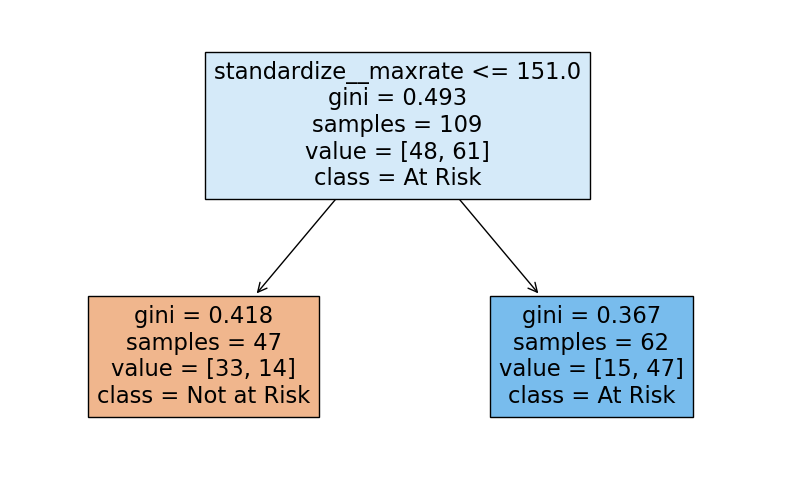

In [133]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Extract decision tree model 
decision_tree_model = dt_pipeline35.named_steps["decision_tree"]


# Plot 
plt.figure(figsize=(10, 6))  
plot_tree(decision_tree_model, 
          filled=True, 
          feature_names=feature_names, 
          class_names=['Not at Risk', 'At Risk']
         )
plt.show()


For the Decision Tree model with min_samples_leaf = 35, we get a ROC-AUC value of 81.86, which means our model is more effective than random guessing by a pretty significant margin, but also has the lowest ROC-AUC value so far.

# Interpretations

The most important variables in predicting whether an individual is at risk of a heart attack were the following: 

In the logistic regression model, the largest negative coefficient (-1.36) was the typical angina chest pain indicator (chestpain = 0). All other types of chest pain had positive coefficients which suggests the other types of pain are more likely to be at risk of a heart attack given the model. Furthermore, the 'sex' variable had large coefficients with values of 1.24 (0) and -1.24 (1) suggesting that being a female reduces the chance of an indivual being at risk which makes sense intuitively as more men are at risk of a heart attack. Lastly, the maximimum heart rate of an individual had a relatively large coefficient (0.78) and makes sense as an important predictor variable as higher heart rates are present in stressed out or unhealthy individuals.

In the Decision Tree, the maximum heart rate variable was the most important classifier, and after tuning min_samples_leaf was set to 35 to optimize ROC-AUC value. According to the model, the tree splits on a max heart rate of 151.

## ROC Curve Plots

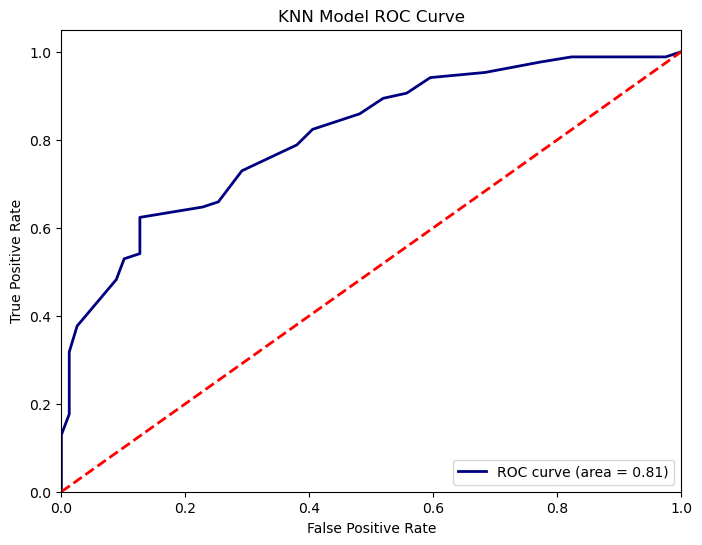

KNN ROC AUC: 0.81


In [134]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Predict probabilities
probs = knn_model.predict_proba(X_test)
# Keep probabilities for the positive outcome only
probs = probs[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='navy', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN Model ROC Curve')
plt.legend(loc="lower right")
plt.show()

print(f"KNN ROC AUC: {roc_auc:.2f}")


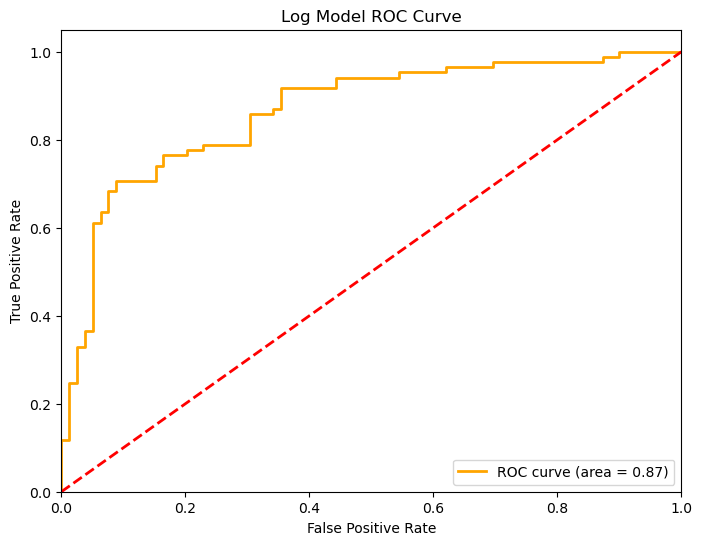

KNN ROC AUC: 0.87


In [135]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Predict probabilities
probs = log_model.predict_proba(X_test)
# Keep probabilities for the positive outcome only
probs = probs[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Log Model ROC Curve')
plt.legend(loc="lower right")
plt.show()

print(f"KNN ROC AUC: {roc_auc:.2f}")

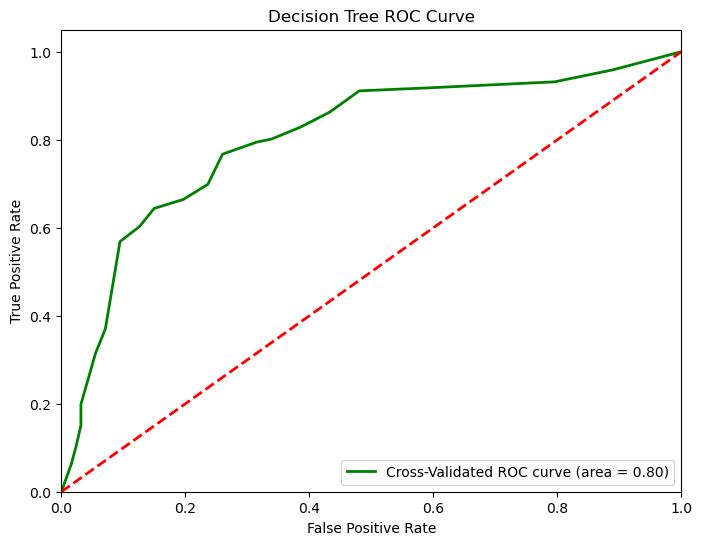

In [136]:
from sklearn.model_selection import cross_val_predict
# Get predicted probabilities using cross-validation
probs = cross_val_predict(dt_model, X, y, cv=5, method='predict_proba')

# Keep probabilities for the positive outcome only
probs = probs[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y, probs)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', lw=2, label=f'Cross-Validated ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve')
plt.legend(loc="lower right")
plt.show()


# Part Two: Metrics

### KNN

In [137]:
#Get metrics from KNN
tn, fp, fn, tp = knnconf_matrix.ravel()

#Calc metrics
knnprecision = tp / (tp + fp)  
knnrecall = tp / (tp + fn)    
knnspecificity = tn / (tn + fp)  


print(f"KNN Precision: {knnprecision}")
print(f"KNN Recall (True Positive Rate): {knnrecall}")
print(f"KNN Specificity (True Negative Rate): {knnspecificity}")

KNN Precision: 0.6907216494845361
KNN Recall (True Positive Rate): 0.788235294117647
KNN Specificity (True Negative Rate): 0.620253164556962


### Logistic Regression

In [138]:
#Get metrics from Log model

tn, fp, fn, tp = logconf_matrix.ravel()

#Calc metrics
logprecision = tp / (tp + fp)  
logrecall = tp / (tp + fn)    
logspecificity = tn / (tn + fp)  


print(f"Logistic Model Precision: {logprecision}")
print(f"Logistic Model Recall (True Positive Rate): {logrecall}")
print(f"Logistic Model Specificity (True Negative Rate): {logspecificity}")

Logistic Model Precision: 0.7373737373737373
Logistic Model Recall (True Positive Rate): 0.8588235294117647
Logistic Model Specificity (True Negative Rate): 0.6708860759493671


### Decision Tree

In [139]:
#Get metrics from DT

tn, fp, fn, tp = dtconf_matrix.ravel()

#Calc metrics
dtprecision = tp / (tp + fp)  
dtrecall = tp / (tp + fn)    
dtspecificity = tn / (tn + fp)  


print(f"Decision Tree Precision: {dtprecision}")
print(f"Decision Tree Recall (True Positive Rate): {dtrecall}")
print(f"Decision Tree Specificity (True Negative Rate): {dtspecificity}")

Decision Tree Precision: 0.6790123456790124
Decision Tree Recall (True Positive Rate): 0.6470588235294118
Decision Tree Specificity (True Negative Rate): 0.6708860759493671


# Part Three: Discussion

#### Q1: The hospital faces severe lawsuits if they deem a patient to be low risk, and that patient later experiences a heart attack.

In this scenario, you would want a model with the highest sensitivity/recall (True Positive Rate). A high sensitivity ensures that the patients who are at risk of a heart attack but are incorrectly labled as low risk (false negatives) is minimized. In this case, you would use the logistic regression model as it has the highest sensitivity of all the models with a sensitivity rate of 0.8588. 85.88% of the time patients who are classified as at risk are truly at risk.

#### Q2: The hospital is overfull, and wants to only use bed space for patients most in need of monitoring due to heart attack risk.

In this scenario, you would want a model with the highest precision to reduce false positives, as false positives would result in patients who are not at risk using the limited bedspace. In this case, you would use the logistic regression model as it has the highest precision rate of all the models with a precision rate of 0.7373. 73.73% of the time patients who are at risk are predicted to be at risk.

#### Q3: The hospital is studying root causes of heart attacks, and would like to understand which biological measures are associated with heart attack risk.

In this scenario, I would choose to use both the logistic regression and decision tree models due to not being able to directly interpret variables within KNN models. As mentioned above, we were able to identify the most influential predictors because those logistic and decision tree models are able to be interpreted.

#### Q4: The hospital is training a new batch of doctors, and they would like to compare the diagnoses of these doctors to the predictions given by the algorithm to measure the ability of new doctors to diagnose patients.

In this scenario you assess the doctors predictions and create a confusion matrix from the results. You would then compare the doctor confusion matrix to other models and make your decision based from there depending on the circumstances. Ideally, you would want one of the machine-learning methods to be superior so you would not have to rely on the same batch of doctors.

# Part Four: Validation

In [140]:
#Load in validation set and apply same changes to assess prediction performance
valheart = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")
valheart = valheart.dropna()
valheart.rename(columns={'output': 'risk', 'cp': 'chestpain', 'trtbps': 'rbps', 'thalach': 'maxrate'}, inplace=True)
valheart['risk'] = valheart['risk'].astype('category')
valheart['sex'] = valheart['sex'].astype('category')
valheart['chestpain'] = valheart['chestpain'].astype('category')
valheart['restecg'] = valheart['restecg'].astype('category')
valheart.head()

,age,sex,chestpain,rbps,chol,restecg,maxrate,risk
0,41,0,1,130,204,0,172,1
1,64,1,3,110,211,0,144,1
2,59,1,0,135,234,1,161,1
3,42,1,0,140,226,1,178,1
4,40,1,3,140,199,1,178,1


In [141]:
X_val = valheart.drop(["risk"],axis=1)
y_val = valheart["risk"]

### KNN Validation

In [142]:
# KNN Validation
knn_val_pred = knn_pipeline50.predict(X_val)
knn_val_pred_proba = knn_pipeline50.predict_proba(X_val)[:, 1]  

# Calculate metrics
knn_val_roc_auc = roc_auc_score(y_val, knn_val_pred_proba)
knn_val_precision = precision_score(y_val, knn_val_pred)
knn_val_recall = recall_score(y_val, knn_val_pred)

# Confusion Matrix
knn_val_conf_matrix = confusion_matrix(y_val, knn_val_pred)

# Print the results
print("KNN Validation Confusion Matrix:")
print(knn_val_conf_matrix)
print(f"KNN Validation ROC AUC: {knn_val_roc_auc}")
print(f"KNN Validation Precision: {knn_val_precision}")
print(f"KNN Validation Recall: {knn_val_recall}")


KNN Validation Confusion Matrix:
[[ 8  3]
 [ 4 15]]
KNN Validation ROC AUC: 0.8827751196172249
KNN Validation Precision: 0.8333333333333334
KNN Validation Recall: 0.7894736842105263


The KNN model performed considerably better than expected by exceeding every metric from the metrics on the original dataset. It performed the best out of all the models when using the validation data, slightly edging out the logistic model.

### Logistic Model Validation

In [143]:
# Log Validation
log_val_pred = log_pipeline.predict(X_val)
log_val_pred_proba = log_pipeline.predict_proba(X_val)[:, 1]  

# Calculate metrics
log_val_roc_auc = roc_auc_score(y_val, log_val_pred_proba)
log_val_precision = precision_score(y_val, log_val_pred)
log_val_recall = recall_score(y_val, log_val_pred)

# Confusion Matrix
log_val_conf_matrix = confusion_matrix(y_val, log_val_pred)

# Print the results
print("LOG Validation Confusion Matrix:")
print(log_val_conf_matrix)
print(f"LOG Validation ROC AUC: {log_val_roc_auc}")
print(f"LOG Validation Precision: {log_val_precision}")
print(f"LOG Validation Recall: {log_val_recall}")


LOG Validation Confusion Matrix:
[[ 8  3]
 [ 5 14]]
LOG Validation ROC AUC: 0.8755980861244019
LOG Validation Precision: 0.8235294117647058
LOG Validation Recall: 0.7368421052631579


The logistic model had a better ROC AUC score when using the validation dataset but underperformed from the metrics (precision and recall) on the original dataset.

### Decision Tree Validation

In [144]:
# DT Validation
dt_val_pred = dt_pipeline35.predict(X_val)
dt_val_pred_proba = dt_pipeline35.predict_proba(X_val)[:, 1]  

# Calculate metrics
dt_val_roc_auc = roc_auc_score(y_val, dt_val_pred_proba)
dt_val_precision = precision_score(y_val, dt_val_pred)
dt_val_recall = recall_score(y_val, dt_val_pred)

# Confusion Matrix
dt_val_conf_matrix = confusion_matrix(y_val, dt_val_pred)

# Print the results
print("DT Validation Confusion Matrix:")
print(dt_val_conf_matrix)
print(f"DT Validation ROC AUC: {dt_val_roc_auc}")
print(f"DT Validation Precision: {dt_val_precision}")
print(f"DT Validation Recall: {dt_val_recall}")



DT Validation Confusion Matrix:
[[ 8  3]
 [ 5 14]]
DT Validation ROC AUC: 0.7320574162679426
DT Validation Precision: 0.8235294117647058
DT Validation Recall: 0.7368421052631579


The Decision Tree model had a worse ROC AUC score under the validation data but performed better than the original data in every other metric from the confusion matrix.

Overall, the models had some differences but were in the same ballpark in terms of values for each metric. The KNN and logistic models remain very close together in terms of metric performance.

# Part Five: Cohen's Kappa

In [145]:
from sklearn.metrics import cohen_kappa_score

In [146]:
#Calc Cohen's Kappa for Each Model
knn_cohen = cohen_kappa_score(y_test,knn_ypred)
log_cohen = cohen_kappa_score(y_test,log_ypred)
dt_cohen = cohen_kappa_score(y_test,dt_ypred)

print(f"Cohen's Kappa Score for K-Nearest Neighbors: {knn_cohen}")
print(f"Cohen's Kappa Score for Logistic Regression: {log_cohen}")
print(f"Cohen's Kappa Score for Decision Tree: {dt_cohen}")

Cohen's Kappa Score for K-Nearest Neighbors: 0.41069022308728853
Cohen's Kappa Score for Logistic Regression: 0.5330436085718567
Cohen's Kappa Score for Decision Tree: 0.31737773152965654


Our logistic regression model has the largest Cohen's Kappa (0.53) which indicates it has a weak level of agreement with the test data. None of the models performed well by Kappa measurement. Due to the logistic model performing the best, it makes sense that it is most similar with the test data (high kappa) and would not change our conclusions from earlier that the logistic model is superior. This would be a good measurement to use in the previously mentioned scenario with the batch of doctors. We could see whether the doctor's agreed on specific patients and then identify and study those patients that were controversial.